# # Human Segmentation Testing Notebook
# This notebook provides two main functionalities:
# 1. Random visualization of 4 test images with predictions
# 2. Single image inference from file path


# ## Setup and Imports

In [9]:
import yaml
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from src.data.human_dataset import DataLoaderFactory
from src.transforms.custom_transforms import CustomTransforms
from src.models import UNet
from src.utils import dice_score, iou_score, accuracy
import random
from pathlib import Path

# Load configuration
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

device = torch.device(cfg.get("device", "cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: cuda


# ## Load Trained Model


In [10]:
from src.models import UNet
def load_trained_model(checkpoint_path="checkpoints/unet_best.pth"):
    """Load the trained UNet model from checkpoint"""
    
    # Initialize model
    model = UNet(
        n_channels=cfg.get("in_channels", 3),
        n_classes=cfg.get("num_classes", 1)
    ).to(device)
    
    # Load checkpoint
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
    
    # Handle both old and new checkpoint formats
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        # New format with additional info
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
        print(f"Best Dice score: {checkpoint.get('best_dice', 'unknown'):.4f}")
    else:
        # Old format - just state dict
        model.load_state_dict(checkpoint)
        print("Loaded model from checkpoint (old format)")
    
    model.eval()
    return model

# Load the model
model = load_trained_model()


Loaded model from epoch 89
Best Dice score: 0.7767


/tmp/ipykernel_27587/3240305700.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


# ## Block 1: Random 4 Images Visualization

=== Random 4 Images Visualization ===
DataLoaderFactory method not found. Trying direct dataset approach...


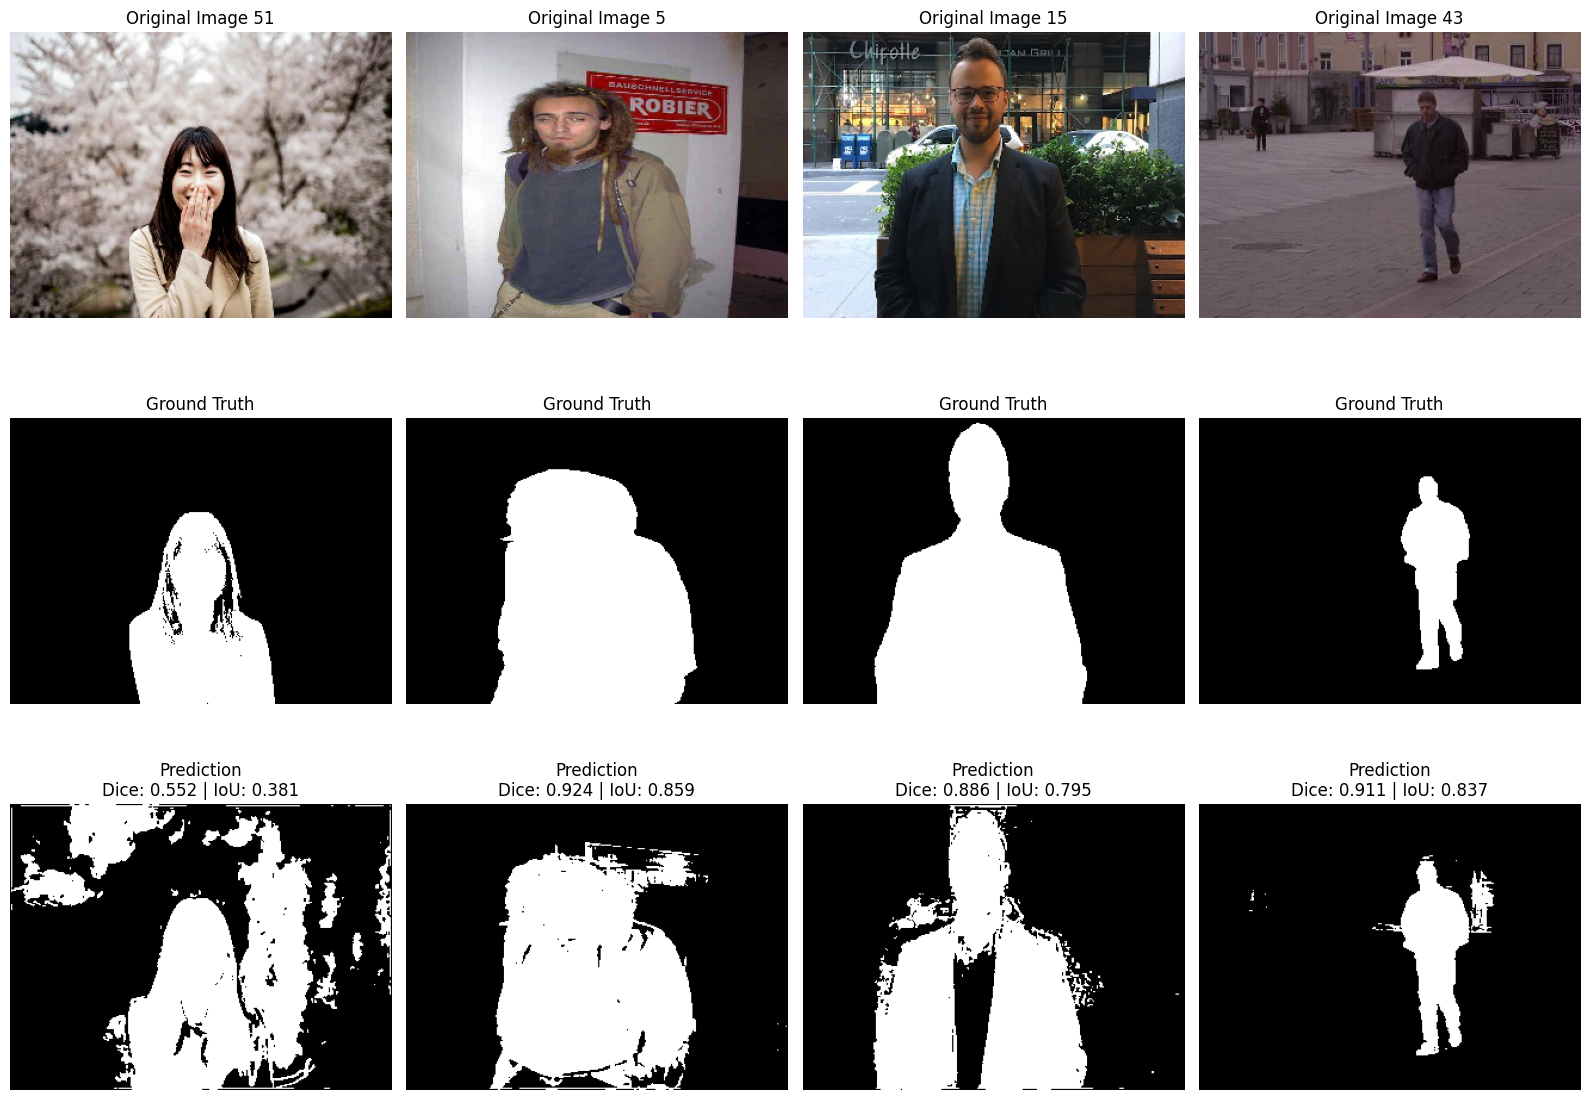

Successfully visualized images at indices: [51, 5, 15, 43]


In [13]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
from torch.utils.data import DataLoader
from src.data.human_dataset import HumanSegmentationDataset, DataLoaderFactory

def create_compatible_transform(image_size):
    """Create a transform compatible with HumanSegmentationDataset"""
    return T.Compose([
        T.Resize(image_size),
        T.ToTensor(),
        # Add normalization if your model expects it
        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def visualize_random_predictions(num_images=4):
    """Randomly load and visualize predictions on test images"""
    
    # Create compatible transform for the DataLoaderFactory
    # Note: DataLoaderFactory expects standard transforms, not CustomTransforms
    image_size = (cfg["input_size"][0], cfg["input_size"][1])
    transform = create_compatible_transform(image_size)
    
    # Create test dataloader using DataLoaderFactory
    test_loader = DataLoaderFactory.get_test_dataloader(
        data_root=cfg["data_root"],
        batch_size=1,  # Load one at a time for random selection
        num_workers=cfg.get("num_workers", 4),
        transform=transform,  # Use compatible transform
        shuffle=False
    )
    
    # Convert to list for random sampling
    test_data = list(test_loader)
    if len(test_data) < num_images:
        print(f"Warning: Only {len(test_data)} test images available, showing all")
        num_images = len(test_data)
    
    # Randomly sample images
    random_indices = random.sample(range(len(test_data)), num_images)
    
    # Create figure
    fig, axes = plt.subplots(3, num_images, figsize=(4*num_images, 12))
    if num_images == 1:
        axes = axes.reshape(-1, 1)
    
    with torch.no_grad():
        for idx, data_idx in enumerate(random_indices):
            images, masks = test_data[data_idx]
            images = images.to(device)
            
            # Handle mask dimensions - ensure it's float and has correct shape
            if len(masks.shape) == 3:  # [H, W] -> add batch and channel dims
                masks = masks.unsqueeze(0).unsqueeze(0).float()
            elif len(masks.shape) == 4 and masks.shape[1] == 1:  # Already [B, 1, H, W]
                masks = masks.float()
            else:
                masks = masks.unsqueeze(1).float()  # Add channel dim if missing
            
            masks = masks.to(device)
            
            # Get prediction
            outputs = model(images)
            pred_mask = torch.sigmoid(outputs) > 0.5
            
            # Calculate metrics
            dice = dice_score(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = accuracy(outputs, masks)
            
            # Convert to numpy for visualization
            image_np = images[0].cpu().numpy()
            
            # Handle image format - check if it's [C, H, W] or [H, W, C]
            if image_np.shape[0] == 3 or image_np.shape[0] == 1:  # [C, H, W]
                image_np = image_np.transpose(1, 2, 0)  # Convert to [H, W, C]
            
            # Handle single channel images
            if image_np.shape[2] == 1:
                image_np = image_np.squeeze(2)  # Remove single channel dimension
            
            # Denormalize image for display
            if image_np.max() <= 1.0:  # If values are in [0, 1]
                image_np = np.clip(image_np, 0, 1)
            else:  # If values are in different range
                image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
            
            # Extract mask and prediction
            if len(masks.shape) == 4:
                mask_np = masks[0, 0].cpu().numpy()
            else:
                mask_np = masks[0].cpu().numpy()
                
            if len(pred_mask.shape) == 4:
                pred_np = pred_mask[0, 0].cpu().numpy()
            else:
                pred_np = pred_mask[0].cpu().numpy()
            
            # Plot original image
            if len(image_np.shape) == 3 and image_np.shape[2] == 3:  # RGB
                axes[0, idx].imshow(image_np)
            else:  # Grayscale
                axes[0, idx].imshow(image_np, cmap='gray')
            axes[0, idx].set_title(f'Original Image {data_idx}')
            axes[0, idx].axis('off')
            
            # Plot ground truth mask
            axes[1, idx].imshow(mask_np, cmap='gray')
            axes[1, idx].set_title('Ground Truth')
            axes[1, idx].axis('off')
            
            # Plot prediction
            axes[2, idx].imshow(pred_np, cmap='gray')
            axes[2, idx].set_title(f'Prediction\nDice: {dice:.3f} | IoU: {iou:.3f}')
            axes[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    return random_indices

# Alternative version if you need to maintain CustomTransforms
def visualize_random_predictions_direct(num_images=4):
    """Alternative version that creates dataset directly if transform compatibility issues persist"""
    import os
    
    # Create dataset directly bypassing DataLoaderFactory if needed
    test_image_dir = os.path.join(cfg["data_root"], "test", "images")
    test_mask_dir = os.path.join(cfg["data_root"], "test", "masks")
    
    # Check if CustomTransforms is available and use it, otherwise use standard transforms
    try:
        transform = CustomTransforms(
            is_train=False,
            image_size=(cfg["input_size"][0], cfg["input_size"][1])
        )
    except NameError:
        # Fallback to standard transforms
        transform = create_compatible_transform((cfg["input_size"][0], cfg["input_size"][1]))
    
    # Create dataset and dataloader directly
    test_dataset = HumanSegmentationDataset(
        test_image_dir, 
        test_mask_dir, 
        transform=transform
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=1, 
        shuffle=False, 
        num_workers=cfg.get("num_workers", 4)
    )
    
    # Rest of the visualization code is the same
    test_data = list(test_loader)
    if len(test_data) < num_images:
        print(f"Warning: Only {len(test_data)} test images available, showing all")
        num_images = len(test_data)
    
    random_indices = random.sample(range(len(test_data)), num_images)
    
    fig, axes = plt.subplots(3, num_images, figsize=(4*num_images, 12))
    if num_images == 1:
        axes = axes.reshape(-1, 1)
    
    with torch.no_grad():
        for idx, data_idx in enumerate(random_indices):
            images, masks = test_data[data_idx]
            images = images.to(device)
            
            # Handle mask dimensions
            if len(masks.shape) == 3:
                masks = masks.unsqueeze(0).unsqueeze(0).float()
            elif len(masks.shape) == 4 and masks.shape[1] == 1:
                masks = masks.float()
            else:
                masks = masks.unsqueeze(1).float()
            
            masks = masks.to(device)
            
            outputs = model(images)
            pred_mask = torch.sigmoid(outputs) > 0.5
            
            dice = dice_score(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = accuracy(outputs, masks)
            
            # Image processing for display
            image_np = images[0].cpu().numpy()
            if image_np.shape[0] == 3 or image_np.shape[0] == 1:
                image_np = image_np.transpose(1, 2, 0)
            
            if image_np.shape[2] == 1:
                image_np = image_np.squeeze(2)
            
            if image_np.max() <= 1.0:
                image_np = np.clip(image_np, 0, 1)
            else:
                image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
            
            mask_np = masks[0, 0].cpu().numpy() if len(masks.shape) == 4 else masks[0].cpu().numpy()
            pred_np = pred_mask[0, 0].cpu().numpy() if len(pred_mask.shape) == 4 else pred_mask[0].cpu().numpy()
            
            if len(image_np.shape) == 3 and image_np.shape[2] == 3:
                axes[0, idx].imshow(image_np)
            else:
                axes[0, idx].imshow(image_np, cmap='gray')
            axes[0, idx].set_title(f'Original Image {data_idx}')
            axes[0, idx].axis('off')
            
            axes[1, idx].imshow(mask_np, cmap='gray')
            axes[1, idx].set_title('Ground Truth')
            axes[1, idx].axis('off')
            
            axes[2, idx].imshow(pred_np, cmap='gray')
            axes[2, idx].set_title(f'Prediction\nDice: {dice:.3f} | IoU: {iou:.3f}')
            axes[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    return random_indices

# Main execution with error handling
if __name__ == "__main__":
    print("=== Random 4 Images Visualization ===")
    try:
        # Try the main function first
        random_indices = visualize_random_predictions(4)
        print(f"Successfully visualized images at indices: {random_indices}")
    except AttributeError as e:
        if "get_test_dataloader" in str(e):
            print("DataLoaderFactory method not found. Trying direct dataset approach...")
            try:
                random_indices = visualize_random_predictions_direct(4)
                print(f"Successfully visualized images at indices: {random_indices}")
            except Exception as e2:
                print(f"Direct approach also failed: {e2}")
        else:
            print(f"AttributeError: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
        print("Trying direct dataset approach...")
        try:
            random_indices = visualize_random_predictions_direct(4)
            print(f"Successfully visualized images at indices: {random_indices}")
        except Exception as e2:
            print(f"Direct approach also failed: {e2}")

# ## Block 2: Single Image Inference from Path


In [14]:
def preprocess_single_image(image_path, target_size=(320, 240)):
    """Preprocess a single image for inference"""
    
    # Load image
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Define preprocessing transforms
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        # Add normalization if your model was trained with it
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Apply transforms
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    return image_tensor, image, original_size

def predict_single_image(image_path, confidence_threshold=0.5, save_result=False):
    """
    Predict segmentation mask for a single image
    
    Args:
        image_path: Path to input image
        confidence_threshold: Threshold for binary prediction (default: 0.5)
        save_result: Whether to save the result
    """
    
    print(f"Processing image: {image_path}")
    
    # Preprocess image
    image_tensor, original_image, original_size = preprocess_single_image(
        image_path, 
        target_size=(cfg["input_size"][1], cfg["input_size"][0])  # (width, height)
    )
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Inference
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.sigmoid(outputs)
        binary_mask = probabilities > confidence_threshold
    
    # Convert to numpy
    prob_mask = probabilities[0, 0].cpu().numpy()
    binary_mask_np = binary_mask[0, 0].cpu().numpy()
    
    # Resize back to original size
    prob_mask_resized = np.array(Image.fromarray(prob_mask).resize(original_size, Image.BILINEAR))
    binary_mask_resized = np.array(Image.fromarray(binary_mask_np.astype(np.uint8) * 255).resize(original_size, Image.NEAREST))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Original image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Probability map
    im1 = axes[0, 1].imshow(prob_mask_resized, cmap='hot', vmin=0, vmax=1)
    axes[0, 1].set_title('Probability Map')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Binary mask
    axes[1, 0].imshow(binary_mask_resized, cmap='gray')
    axes[1, 0].set_title(f'Binary Mask (threshold={confidence_threshold})')
    axes[1, 0].axis('off')
    
    # Overlay
    overlay = np.array(original_image).copy()
    human_pixels = binary_mask_resized > 128
    overlay[human_pixels] = overlay[human_pixels] * 0.7 + np.array([255, 0, 0]) * 0.3  # Red overlay
    axes[1, 1].imshow(overlay.astype(np.uint8))
    axes[1, 1].set_title('Overlay (Human in Red)')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save results if requested
    if save_result:
        save_dir = "inference_results"
        os.makedirs(save_dir, exist_ok=True)
        
        image_name = Path(image_path).stem
        
        # Save probability map
        prob_path = os.path.join(save_dir, f"{image_name}_probability.png")
        Image.fromarray((prob_mask_resized * 255).astype(np.uint8)).save(prob_path)
        
        # Save binary mask
        mask_path = os.path.join(save_dir, f"{image_name}_mask.png")
        Image.fromarray(binary_mask_resized).save(mask_path)
        
        # Save overlay
        overlay_path = os.path.join(save_dir, f"{image_name}_overlay.png")
        Image.fromarray(overlay.astype(np.uint8)).save(overlay_path)
        
        print(f"Results saved to {save_dir}/")
    
    # Print statistics
    human_percentage = (binary_mask_resized > 128).sum() / binary_mask_resized.size * 100
    max_confidence = prob_mask_resized.max()
    mean_confidence = prob_mask_resized[binary_mask_resized > 128].mean() if (binary_mask_resized > 128).any() else 0
    
    print(f"Human pixels: {human_percentage:.1f}% of image")
    print(f"Max confidence: {max_confidence:.3f}")
    print(f"Mean confidence (human regions): {mean_confidence:.3f}")
    
    return prob_mask_resized, binary_mask_resized

# ## Interactive Single Image Prediction
# **Change the image path below to test your own images**


In [ ]:
# Example usage - CHANGE THIS PATH TO YOUR IMAGE
image_path = "path/to/your/test/image.jpg"  # <-- CHANGE THIS

# Uncomment and run the line below with your image path
# predict_single_image(image_path, confidence_threshold=0.5, save_result=True)

In [ ]:
print("To test a single image:")
print("1. Change the 'image_path' variable above to your image path")
print("2. Uncomment and run the predict_single_image() function")
print("3. Adjust confidence_threshold if needed (0.3-0.7 range typically works well)")


# ## Batch Evaluation on Test Set

In [ ]:
def evaluate_test_set():
    """Evaluate model on entire test set"""
    
    test_loader = DataLoaderFactory.get_test_dataloader(
        data_root=cfg["data_root"],
        batch_size=cfg["batch_size"],
        num_workers=cfg.get("num_workers", 4),
        transform=CustomTransforms(
            is_train=False,
            image_size=(cfg["input_size"][0], cfg["input_size"][1])
        )
    )
    
    total_acc = 0.0
    total_dice = 0.0
    total_iou = 0.0
    n_batches = 0
    
    print("Evaluating on test set...")
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device).float()
            outputs = model(images)
            
            total_acc += accuracy(outputs, masks)
            total_dice += dice_score(outputs, masks)
            total_iou += iou_score(outputs, masks)
            n_batches += 1
    
    avg_acc = total_acc / n_batches
    avg_dice = total_dice / n_batches
    avg_iou = total_iou / n_batches
    
    print(f"\n=== Test Set Evaluation Results ===")
    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average Dice:     {avg_dice:.4f}")
    print(f"Average IoU:      {avg_iou:.4f}")
    
    return avg_acc, avg_dice, avg_iou

In [ ]:
# Uncomment to run evaluation on test set
# evaluate_test_set()

# %% [markdown]
# ## Usage Instructions
# 
# ### For Random Visualization:
# - Simply run the "Random 4 Images Visualization" block
# - It will randomly select 4 images from your test set and show predictions
# 
# ### For Single Image Inference:
# 1. Change the `image_path` variable to point to your image
# 2. Uncomment the `predict_single_image()` function call
# 3. Adjust `confidence_threshold` if needed (0.3-0.7 typically works well)
# 4. Set `save_result=True` to save the results to disk
# 
# ### Parameters you can adjust:
# - `confidence_threshold`: Higher values = more conservative predictions
# - `save_result`: Set to True to save probability maps, masks, and overlays
# - `num_images`: Change number of random images to visualize